# FBN1

This notebook demonstrates how to use genophenocorr to search for correlations between certain tpes of variant and specific disease genetities.

FBN1 encodes the fibrillin-1 protein. Pathogenic variants in FBN1 are found in Marfan syndrome and a number of other disorders including  [Weill-Marchesani syndrome](https://omim.org/entry/608328) (WMS), [geleophysic dysplasia](https://omim.org/entry/231050) (GPHYSD), [acromicric dysplasia](https://omim.org/entry/102370) (ACMICD), and [Marfan lipodystrophy syndrome](https://omim.org/entry/616914).

We will investigate correlations between variant location and disease diagnosis.

### Set up
First import the libraries and define the transcript and diseases of interest.

In [2]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.2.1.dev0


Some *FBN1* metadata:

In [3]:
FBN1_MANE_transcript = 'NM_000138.5'
FBN1_protein_id = "NP_000129.3"

### Load the cohort

We will load phenopackets from the *FBN1* cohort of Phenopacket Store `0.1.18`.

In [5]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort_name = 'FBN1'
phenopacket_store_release = '0.1.18'

registry = configure_phenopacket_registry()
with registry.open_phenopacket_store(phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(cohort_name))

cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
del phenopackets
validation.summarize()

Patients Created: 100%|██████████| 151/151 [00:00<00:00, 468.27it/s]
Validated under none policy
No errors or warnings were found


In [6]:
from gpsea.view import CohortViewable
from IPython.display import HTML, display

viewer = CohortViewable(hpo)
display(HTML(viewer.process(cohort=cohort, transcript_id=FBN1_MANE_transcript)))

HPO Term,ID,Seen in n individuals
Ectopia lentis,HP:0001083,82
Myopia,HP:0000545,70
Arachnodactyly,HP:0001166,54
Aortic root aneurysm,HP:0002616,34
High palate,HP:0000218,33
Short stature,HP:0004322,32
Short palm,HP:0004279,32
Short foot,HP:0001773,32
Scoliosis,HP:0002650,30
Tall stature,HP:0000098,29


In [7]:
from gpsea.preprocessing import configure_protein_metadata_service
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.model.genome import GRCh38

pms = configure_protein_metadata_service()
protein_meta = pms.annotate(FBN1_protein_id)
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(FBN1_MANE_transcript)

In [8]:
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

In [9]:
viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
N-terminal domain,region,45 - 450,8
Fibrillin unique N-terminal (FUN) domain,region,45 - 81,3
EGF-like 1,domain,81 - 112,0
EGF-like 2,domain,115 - 146,2
Interaction with MFAP4,region,119 - 329,4
EGF-like 3,domain,147 - 178,1
TB 1,domain,184 - 236,0
Hybrid domain 1,region,195 - 221,0
EGF-like 4; calcium-binding,domain,246 - 287,0
EGF-like 5; calcium-binding,domain,288 - 329,0


<Axes: title={'center': 'Fibrillin-1\ntranscript: NM_000138.5, protein: NP_000129.3'}>

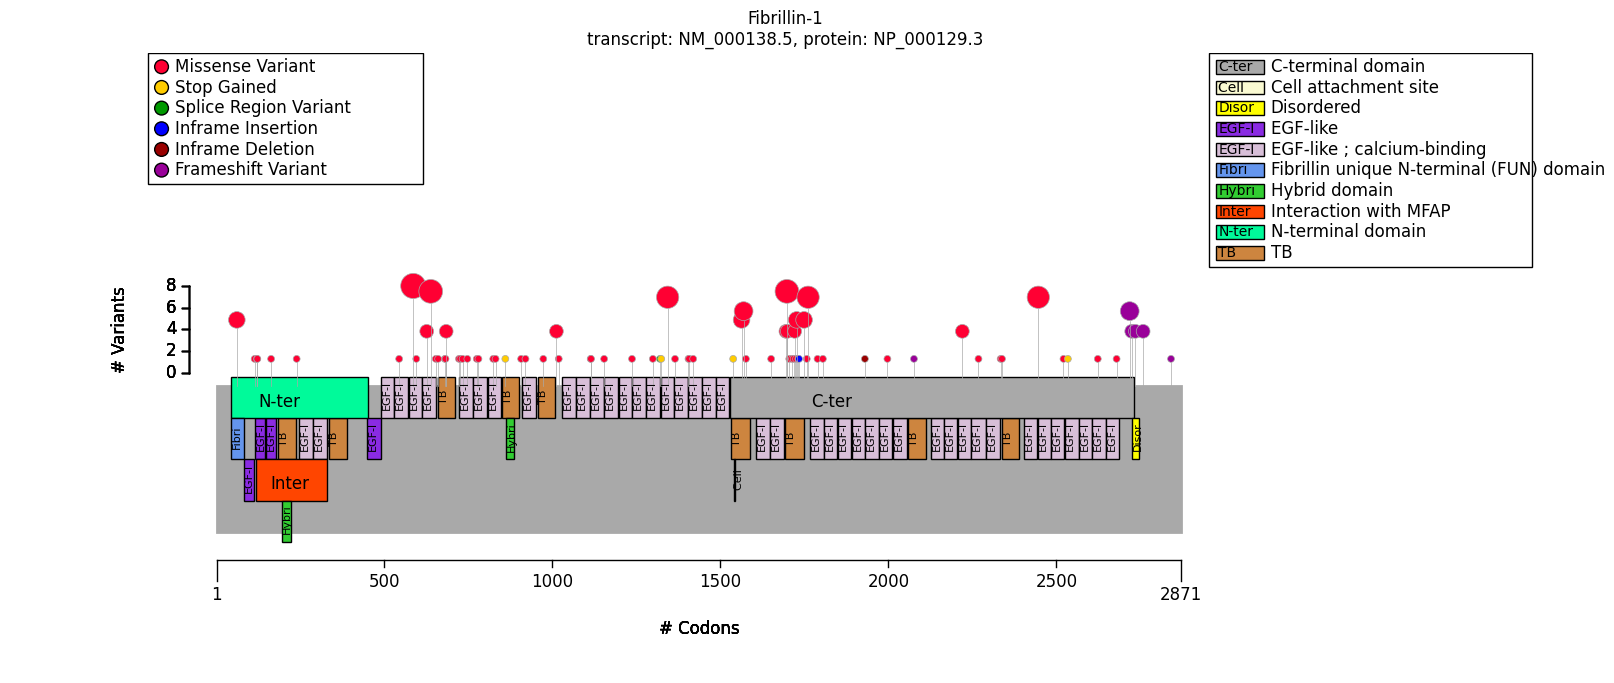

In [10]:
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [11]:
from gpsea.analysis import configure_cohort_analysis, CohortAnalysisConfiguration
from gpsea.analysis.predicate import PatientCategories
from gpsea.model.genome import Region

analysis_config = CohortAnalysisConfiguration()
analysis_config.missing_implies_excluded = False

analysis = configure_cohort_analysis(cohort, hpo, config=analysis_config)

In [12]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates

missense_predicate = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=FBN1_MANE_transcript)
missense = analysis.compare_hpo_vs_genotype(missense_predicate)
missense.summarize(hpo, PatientCategories.YES)

MISSENSE_VARIANT on NM_000138.5                       Yes  ...                  
                                                    Count  ... Corrected p value
Finger joint hypermobility [HP:0006094]              0/28  ...          0.000078
Arachnodactyly [HP:0001166]                         34/65  ...          0.292682
Abnormal upper to lower segment ratio [HP:0012772]    7/7  ...          0.419580
High palate [HP:0000218]                            19/51  ...          0.525343
Hyperextensibility of the finger joints [HP:000...   0/28  ...          0.549853
...                                                   ...  ...               ...
Abnormal renal morphology [HP:0012210]                0/0  ...          1.000000
Abnormality of prenatal development or birth [H...    0/0  ...          1.000000
Abnormality of the cardiovascular system [HP:00...  41/41  ...          1.000000
Strabismus [HP:0000486]                              3/28  ...          1.000000
Abnormality of the respiratory system [HP:0002086]    8/8  ...          1.000000

[300 rows x 6 columns]

In [15]:
results = analysis.compare_disease_vs_genotype(
    predicate=missense_predicate, 
    disease_ids=("OMIM:614185",),
)

results.summarize(hpo, category=PatientCategories.YES)

MISSENSE_VARIANT on NM_000138.5     Yes          ...                            
                                  Count Percent  ...   p value Corrected p value
OMIM:614185                      19/119     16%  ...  0.013613          0.013613

[1 rows x 6 columns]

In [18]:
from gpsea.analysis.predicate.genotype import ProteinPredicates

prot_pred = ProteinPredicates(pms)
prot_feat_pred = prot_pred.protein_feature("TB 7", tx_id=FBN1_MANE_transcript)

prot_results = analysis.compare_hpo_vs_genotype(prot_feat_pred)
prot_results.summarize(hpo, PatientCategories.YES)

Variant that affects TB 7 feature on the protein encoded by transcript NM_000138.5   Yes  ...                  
                                                                                   Count  ... Corrected p value
Mitral stenosis [HP:0001718]                                                        4/13  ...               1.0
Tricuspid stenosis [HP:0010446]                                                     3/12  ...               1.0
Abnormal blood vessel morphology [HP:0033353]                                        0/0  ...               1.0
Abnormal jaw morphology [HP:0030791]                                                 0/0  ...               1.0
Abnormality of the vasculature [HP:0002597]                                          0/0  ...               1.0
...                                                                                  ...  ...               ...
Abnormal renal morphology [HP:0012210]                                               0/0  ...               1.0
Abnormality of prenatal development or birth [H...                                   0/0  ...               1.0
Abnormality of the cardiovascular system [HP:00...                                   9/9  ...               1.0
Strabismus [HP:0000486]                                                              0/0  ...               1.0
Abnormality of the respiratory system [HP:0002086]                                   7/7  ...               1.0

[300 rows x 6 columns]

*-* EOF *-*